# Post-process

While `eodag` 's main goal is to offer an easy way to search and download EO products, it doesn't want to be a dead-end to its users. 

## Products file path

The download methods all return the local path of each product downloaded. Theses paths can be fed into another program for further processing.

## Sentinel: SAFE Format

Sentinel products are generally distributed in the [SAFE format](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats). AWS-based providers however offers Sentinel products in a splitted way. `eodag` automatically builds a SAFE product out of multiple files it downloads. Image processing softwares such as *SNAP* work well with products in the SAFE format.

## Data access with `eodag-cube`

At some point `eodag` had some capabilities to directly post-process a product, i.e. to access its data. These capabilities, which relied on [rasterio](https://rasterio.readthedocs.io/en/latest/), have been ported to the Python package [eodag-cube](https://github.com/CS-SI/eodag-cube) to avoid the heavy dependencies associated with *rasterio* and *GDAL*. Installing this package is enough to benefit from its capabilities, it is going to extend `EOProduct` with a `get_data` which returns a product's image band as a `xarray.DataArray`.



### Setup

A *Sentinel 2 Level-1C* product will be downloaded from *PEPS*, whose credentials need to be set. The product will be downloaded in a dedicated sub-directory.

<div class="alert alert-warning">

Warning

`eodag-cube` needs to be installed to run correcly the following code.

</div>

In [1]:
import os
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = "PLEASE_CHANGE_ME"
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = "PLEASE_CHANGE_ME"

In [2]:
workspace = 'eodag_workspace_post_process'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

In [3]:
os.environ["EODAG__PEPS__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.abspath(workspace)

In [4]:
from eodag import EODataAccessGateway
dag = EODataAccessGateway()

In [5]:
search_criteria = {
    "productType": "S2_MSI_L1C",
    "start": "2021-03-01",
    "end": "2021-03-31",
    "geom": {"lonmin": 1, "latmin": 43, "lonmax": 2, "latmax": 44}
}

In [6]:
products, estimated_total_number = dag.search(**search_criteria)

In [7]:
one_product = products[3]

In [8]:
from eodag.utils import NotebookProgressCallback

dag.download(one_product, progress_callback=NotebookProgressCallback())

'file:///home/maxime/TRAVAIL/06_EODAG/01_eodag/eodag/docs/notebooks/api_user_guide/eodag_workspace_post_process/S2B_MSIL1C_20210328T103629_N0209_R008_T31TDJ_20210328T124650/S2B_MSIL1C_20210328T103629_N0209_R008_T31TDJ_20210328T124650.SAFE'

The method `get_data` requires the following parameters:

* `band`: the band of the dataset to retrieve (e.g. "B01")
* `extent`: the extent on which to extract the data, provided as a tuple (*minx*, *miny*, *maxx*, *maxy*) whose coordinates are in the `crs` coordinate reference system
* `resolution`: the resolution in which the dataset should be returned (given in the unit of the `crs`)
* `crs`: the coordinate reference system in which the dataset should be returned


The example below shows how to calculate the NDVI from the downloaded product.

In [32]:
common_params = dict(
    crs="epsg:4326",
    resolution=0.0001,
    extent=(1.435905, 43.586857, 1.458907, 43.603827)
)
VIR = one_product.get_data(band="B04", **common_params)
NIR = one_product.get_data(band="B08", **common_params)
NDVI = (NIR - VIR * 1.) / (NIR + VIR)

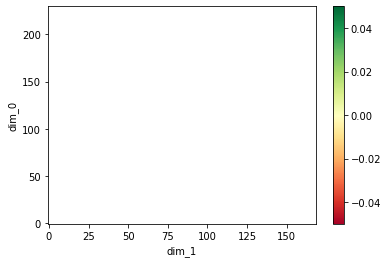

In [33]:
NDVI.plot(cmap="RdYlGn", center=False)